## Imports

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import string
from pathlib import Path
from tqdm import tqdm

## Reading in the excel

In [77]:
df = pd.read_excel(r'data/input/input_results.xlsx')

### Global variables

In [78]:
rows_len, columns_len = df.shape

print("Rows: " + str(rows_len) + ", Columns: " + str(columns_len))

Rows: 2236, Columns: 671


## Cleaning data set

In [79]:
# Drop all columns with only NAN values
clean_data = df.dropna(axis=1, how='all')

In [80]:
# Remove the consent and extra questions at the end from the survey data
clean_data = clean_data.iloc[:,:417]

### Clean the columns

In [81]:
format_column_names = list(clean_data.columns)

In [82]:
# Sanitize the column names that have "\xa0" in the title
for i in range(len(format_column_names)):
    cur_col_name = format_column_names[i]
    if '\xa0' in cur_col_name:
        format_column_names[i] = (' '.join(cur_col_name.split()))
        

In [83]:
# Sanitize the column names that has the form "* [...]" in the title
for i in range(len(format_column_names)):
    cur_col_name = format_column_names[i]
    if '*' in cur_col_name[0]:
        format_column_names[i] = (cur_col_name.lstrip('* [').replace(']','').replace('[',' ').strip())

In [84]:
duplicate_counter = 0
seen_list = []

for i in range(len(format_column_names)):
    cur_col_name = format_column_names[i]
    if(not(cur_col_name in seen_list)):
        seen_list.append(cur_col_name)
    else:
        # Encountered a duplicate column name, hence increment
        duplicate_counter += 1
        
        #Replace the current column name with a unique name
        format_column_names[i] = cur_col_name+"_"+str(duplicate_counter)
    

In [85]:
clean_data.columns = format_column_names

#### Remove rows with NAN responses to the important columns

In [86]:
# Drop all rows with NAN values for the three main features
clean_data = clean_data.dropna(axis=0, subset=['Three main features merged (AS, AT, AU)'])

#### Removing irrelevant columns

These were found by manual inspection

In [87]:
irrelevant_columns = []
with open(r'data/input/dental_irrelevant_columns.txt') as input_file:
    for line in input_file:
        irrelevant_columns.append(line.split("\n")[0])

In [88]:
clean_data = clean_data.drop(labels=irrelevant_columns, axis=1)

#### Removing internal calculations

In [89]:
# Read in the column names where there is an internal calculation present
columns_internal_calculation = []

for col in clean_data.columns:
    # Column names starting with '{' are calculations from other cells in the excel
    if col[0] == '{':
        columns_internal_calculation.append(col)
        
# Check if save directory exists and create if not
Path('./data/output/dental_removed_columns').mkdir(parents=True, exist_ok=True)
        
# Save the column names to a local file
pd.DataFrame(columns_internal_calculation).to_csv(
    'data/output/dental_removed_columns/columns_internal_calculation',
    index=False,header=False)

# Remove the columns from the dataFrame
clean_data = clean_data.drop(labels=columns_internal_calculation, axis=1)

# Clear memory
del columns_internal_calculation

#### Remove group time

In [90]:
# Read in the column names where there is an internal calculation present
columns_group_time = []

for col in clean_data.columns:
    # Column names starting with '{' are calculations from other cells in the excel
    if 'Group time:' in col:
        columns_group_time.append(col)
        
# Check if save directory exists and create if not
Path('./data/output/dental_removed_columns').mkdir(parents=True, exist_ok=True)
        
# Save the column names to a local file
pd.DataFrame(columns_group_time).to_csv(
    'data/output/dental_removed_columns/columns_group_time',
    index=False,header=False)

# Remove the columns from the dataFrame
clean_data = clean_data.drop(labels=columns_group_time, axis=1)

# Clear memory
del columns_group_time

#### Comparison of before and after initial data cleaning

In [91]:
print(df.shape)
print(clean_data.shape)

(2236, 671)
(2128, 359)


In [92]:
print("Change in rows: " +
      str(clean_data.shape[0] - df.shape[0]) +
      "\nChange in columns: " +
      str(clean_data.shape[1] - df.shape[1]))

Change in rows: -108
Change in columns: -312


## Exploration

### Nan count per column

In [93]:
bar_chart1_data = rows_len - df.isna().sum()

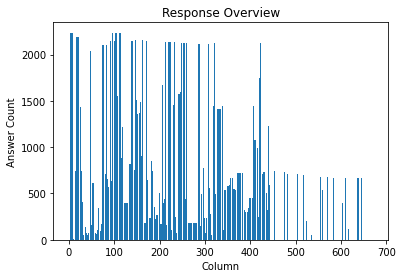

In [94]:
plt.bar(range(len(bar_chart1_data)),bar_chart1_data.values)
plt.title('Response Overview')
plt.xlabel('Column')
plt.ylabel('Answer Count')
plt.show()

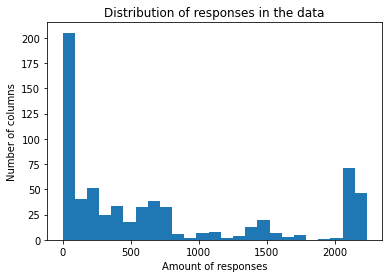

In [95]:
plt.hist(bar_chart1_data, bins=25)
plt.title('Distribution of responses in the data')
plt.xlabel('Amount of responses')
plt.ylabel('Number of columns')
plt.show()

In [96]:
bar_chart2_data = clean_data.shape[0] - clean_data.isna().sum()
bar_chart2_data = bar_chart2_data.sort_values(ascending=False) / clean_data.shape[0]

In [97]:
print("Columns present in the cleaned data set:",len(bar_chart2_data))

Columns present in the cleaned data set: 359


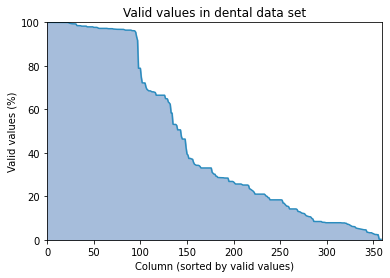

In [98]:
# Description of plot
plt.title('Valid values in dental data set')
plt.xlabel('Column (sorted by valid values)')
plt.ylabel('Valid values (%)')

# Plot the line
plt.plot(range(len(bar_chart2_data)),bar_chart2_data.values*100, color='#2b8cbe')

# Shade the area below the plotted line
plt.fill_between(
    np.arange(0,len(bar_chart2_data)),
    np.zeros(len(bar_chart2_data)),
    bar_chart2_data.values*100,
    color='#a6bddb'
)

# Adjusted settings for visual clarity
plt.ylim([0,100])
plt.xlim([0,len(bar_chart2_data)])

# Check if save directory exists and create if not
Path('./visualization').mkdir(parents=True, exist_ok=True)

plt.savefig('visualization/dental_valid_values.png', dpi=600)

plt.show()

### Finding types of responses

In [99]:
col_types = clean_data.dtypes.astype('string')

In [100]:
pie_chart1_data = col_types.value_counts(dropna=False)

In [101]:
pie_chart1_data.index

Index(['object', 'float64', 'int64'], dtype='string')

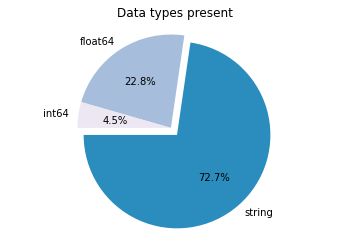

In [102]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['string', 'float64', 'int64']
sizes = pie_chart1_data.values
explode = (0.1, 0, 0)

#add colors
colors = ['#2b8cbe','#a6bddb','#ece7f2']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=180, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.set_title("Data types present")


# Check if save directory exists and create if not
Path('./visualization').mkdir(parents=True, exist_ok=True)

plt.savefig('visualization/dental_data_types.png', dpi=600)

plt.show()

### 'Start language' statistics

In [103]:
clean_data['Start language'].value_counts()

de       2035
en         63
pt-BR      29
th          1
Name: Start language, dtype: int64

In [104]:
(clean_data['Start language'].value_counts() / clean_data.shape[0] ) * 100

de       95.629699
en        2.960526
pt-BR     1.362782
th        0.046992
Name: Start language, dtype: float64

### Determining the data type of each column

In [105]:
unique_types = np.array(col_types.unique())

In [106]:
column_index_list = list(range(0,len(col_types)))

# Declare an empty list
index_type_list = []

for type_name in unique_types:
    temp_list = []
    for i in range(0,len(column_index_list)):
        current = col_types[column_index_list[i]]
        if current == type_name:
            temp_list.append(col_types.index[i])
            
    index_type_list.append(temp_list)
    
    del temp_list


In [107]:
types_dict = dict(zip(unique_types, np.arange(0,len(unique_types))))

In [108]:
types_dict

{'int64': 0, 'object': 1, 'float64': 2}

### Seperating the date time from the object types in the index_type_list

In [109]:
#TODO remove date-time entry from the index_type_list[1] (object) to a new place in that list

In [110]:
date_column_list = []

# Method for searching the value in the dataset
for i in tqdm(range(0,len(clean_data.columns))):
    for j in range(0,len(clean_data)):
        cur_value = clean_data.iloc[j,i]
        try:
            datetime.datetime.strptime(str(cur_value), '%Y-%m-%d %H:%M:%S')
            date_column_list.append(clean_data.columns[i])
            break
        except ValueError:
            pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [00:12<00:00, 28.41it/s]


In [111]:
# Add a new list that represents datetime, while removing those entries from the 'object' list from index_type_list
index_type_list.append(date_column_list)
types_dict['datetime'] = 3

for col_name in date_column_list:
    index_type_list[types_dict['object']].remove(col_name)

In [112]:
# Finding the response amounts per column
column_response_amounts = clean_data[index_type_list[types_dict['object']]].nunique().sort_values()

In [113]:
# Taking the columns where there are more than 16 unique responses
text_columns = list(column_response_amounts.index[np.where(column_response_amounts > 16)])
text_columns.reverse()

In [114]:
# Remove certain columns from the text_columns due to unneeded information
text_columns.remove('Pension claim or pension because of:')
text_columns.remove('Do you have any remarks regarding the your medication intake? Please enter them below.')
text_columns.remove('To whom do you feel to be a burden?')


In [115]:
# Select the columns from the data set with text entries in the columns (and unique entries > 16)
text_clean_data = clean_data[text_columns]

In [116]:
# Amount of null values in the text data set
text_clean_data.isnull().sum().sum()

45396

In [117]:
text_clean_data.shape

(2128, 29)

## Unique entries chart

In [118]:
len(text_clean_data.columns)

29

In [119]:
chart3_data_unique = text_clean_data.nunique() / text_clean_data.shape[0]
chart3_data_nan = text_clean_data.isna().sum() / text_clean_data.shape[0]

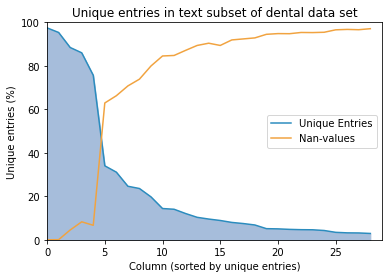

In [120]:
# Description of plot
plt.title('Unique entries in text subset of dental data set')
plt.xlabel('Column (sorted by unique entries)')
plt.ylabel('Unique entries (%)')

x_range_chart3 = range(len(chart3_data_nan))

# Plot the lines
plt.plot(x_range_chart3, chart3_data_unique.values*100, label="Unique Entries", color='#2b8cbe')
plt.plot(x_range_chart3, chart3_data_nan.values*100, label="Nan-values", color='#f1a340')

# Shade the area below the plotted line
plt.fill_between(
    np.arange(0,len(x_range_chart3)),
    np.zeros(len(x_range_chart3)),
    chart3_data_unique.values*100,
    color='#a6bddb'
)

# Adjusted settings for visual clarity
plt.ylim([0,100])
plt.xlim([0,len(x_range_chart3)])
plt.legend(loc='best')

# Check if save directory exists and create if not
Path('./visualization').mkdir(parents=True, exist_ok=True)

plt.savefig('visualization/dental_text_subset_unique.png', dpi=600)

plt.show()

In [121]:
# Amount of nan values in the first 5 columns (sorted)
text_clean_data.iloc[:,:5].isna().sum().sum()

415

### Process the selected text columns

In [206]:
sentences_text_clean_data = list(text_clean_data.to_numpy(na_value="").flatten())

In [207]:
# Remove illegitimate responses from the dataset

sentences_list = []

for entry in sentences_text_clean_data:
    if(
        not(entry == "") and not(entry == ".") and not(entry == "/") and not(entry == "-")
        and not(entry == "--") and not(entry == "---") and not(entry == "----") and not(entry == "-----")
        and not(entry == "------") and not(entry == "-------") and not(entry == "?")
      ):
        sentences_list.append(entry)

In [208]:
# Replacing "\n" by " " so that parsing to txt works well
for i in range(len(sentences_list)):
    if(not type(sentences_list[i]) == str):
        sentences_list[i] = str(sentences_list[i])
    
    #sentences_list[i] = sentences_list[i].lower()
        
    if("\n" in sentences_list[i]):
        sentences_list[i] = sentences_list[i].replace("\n"," ")

#### Imports for nltk processing

In [125]:
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm

In [126]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/thesis-
[nltk_data]     server1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/thesis-
[nltk_data]     server1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Functions

In [201]:
# Function to tokenize a list of sentences
# Input - list of strings
# Output - list of array of words (tokens)
def tokenize_list(sentence_list):
    
    # Loop all the sentences in the list
    for i in tqdm(range(len(sentence_list))):
        current_sentence = str(sentence_list[i]).lower()
        
        if current_sentence == 'nan':
            sentence_list[i] = ['']
        else:
            sentence_list[i] = word_tokenize(current_sentence)
        
    return sentence_list

In [128]:
# Function for removing punctuation as well as german and english stopwords
# Input - list of tokenized sentences
# Output - list of tokenized sentences with desired words removed
def filter_sentences(token_sentence_list):
    
    # Remove 'man' from the german stopwords
    german_stopwords = stopwords.words("german")
    german_stopwords.remove('man')
    
    for i in tqdm(range(len(token_sentence_list))):
        sentence = token_sentence_list[i]

        filter_sentence = []

        for word in sentence:
            if not word in string.punctuation:
                if not (word in stopwords.words("english") or word in german_stopwords):
                    filter_sentence.append(word)

        token_sentence_list[i] = filter_sentence
    
    return token_sentence_list

In [129]:
# Function for writing the responses to a txt file
# Input - filename, list of the text to be saved
# Output - txt file with filename to ./data folder
def write_to_txt(filename, text_list):
    
    #Check whether output directory exists
    Path('./data/output').mkdir(parents=True, exist_ok=True)
    
    with open(f'data/output/{filename}.txt', 'w') as f:
        for sentence in text_list:
            # Check for empty sentences
            if not sentence == []:
                f.write("%s\n" % sentence)

### Process dental dataset for SimCSE training

In [136]:
write_to_txt('dental_simcse_input', sentences_list)

### Process dental dataset for word2vec

In [209]:
# Lower case all the sentences
sentences_list = [sentence.lower() for sentence in sentences_list]

In [210]:
word2vec_input = tokenize_list(sentences_list)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16165/16165 [00:01<00:00, 9514.45it/s]


In [211]:
word2vec_input = filter_sentences(simcse_output)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16165/16165 [00:07<00:00, 2055.34it/s]


In [212]:
write_to_txt('dental_word2vec_input', word2vec_input)

### Process dental data set for clustering SimCSE

In [213]:
cluster_input = []

# Loop all the rows in text_clean_data DataFrame
for i in tqdm(range(text_clean_data.shape[0])):
    # Select the current row
    current_row = text_clean_data.iloc[i]
    
    # Loop all the entries in the current row
    for j in range(text_clean_data.shape[1]):
        cur_value = current_row[j]
        
        cluster_input.append([i,j,cur_value])
        
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2128/2128 [00:06<00:00, 324.49it/s]


In [214]:
cluster_simcse_input = pd.DataFrame(cluster_input)
cluster_simcse_input.columns = ['row','column','sentence']

In [215]:
cluster_simcse_input.to_csv('data/output/cluster_simcse_input.csv')

#### Clustering word2vec

In [200]:
cluster_input

[[0, 0, 'Schmerzen im Kiefergelenk'],
 [0, 1, 'Schmerzfreiheit'],
 [0,
  2,
  'essen vor allem harte, zähe Speisen, wenn das Kissen gegen den Kiefer drückt'],
 [0, 3, 'Essen'],
 [0, 4, 'wenn der Kiefer entspannt ist'],
 [0, 5, 'muss vor allem weiche oder flüssige Speisen zu mir nehmen'],
 [0, 6, nan],
 [0, 7, nan],
 [0, 8, 'essen'],
 [0, 9, nan],
 [0, 10, nan],
 [0, 11, nan],
 [0, 12, nan],
 [0, 13, nan],
 [0, 14, nan],
 [0, 15, 'nein, was alles ok'],
 [0, 16, nan],
 [0, 17, nan],
 [0, 18, nan],
 [0, 19, nan],
 [0, 20, nan],
 [0, 21, 'Sturz mit Velo'],
 [0, 22, nan],
 [0, 23, nan],
 [0, 24, nan],
 [0, 25, nan],
 [0, 26, nan],
 [0, 27, nan],
 [0, 28, 'versuchte eine Nuss mit den Zähnen zu öffnen'],
 [1, 0, 'Headache'],
 [1, 1, 'less pain'],
 [1, 2, 'physical activity, stress'],
 [1, 3, 'Problems with concentration and sleep'],
 [1, 4, 'distraction, rest'],
 [1, 5, nan],
 [1, 6, nan],
 [1, 7, nan],
 [1, 8, nan],
 [1, 9, nan],
 [1, 10, nan],
 [1, 11, 'pain not always on both sides, but mo

In [217]:
cluster_input_text_word2vec_format = tokenize_list(list(np.array(cluster_input).T[2]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61712/61712 [00:01<00:00, 34431.53it/s]


In [219]:
cluster_input_text_word2vec_format = filter_sentences(cluster_input_text_word2vec_format)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61712/61712 [00:12<00:00, 4961.89it/s]


In [204]:
test2

[['schmerzen', 'im', 'kiefergelenk'],
 ['schmerzfreiheit'],
 ['essen',
  'vor',
  'allem',
  'harte',
  ',',
  'zähe',
  'speisen',
  ',',
  'wenn',
  'das',
  'kissen',
  'gegen',
  'den',
  'kiefer',
  'drückt'],
 ['essen'],
 ['wenn', 'der', 'kiefer', 'entspannt', 'ist'],
 ['muss',
  'vor',
  'allem',
  'weiche',
  'oder',
  'flüssige',
  'speisen',
  'zu',
  'mir',
  'nehmen'],
 [''],
 [''],
 ['essen'],
 [''],
 [''],
 [''],
 [''],
 [''],
 [''],
 ['nein', ',', 'was', 'alles', 'ok'],
 [''],
 [''],
 [''],
 [''],
 [''],
 ['sturz', 'mit', 'velo'],
 [''],
 [''],
 [''],
 [''],
 [''],
 [''],
 ['versuchte', 'eine', 'nuss', 'mit', 'den', 'zähnen', 'zu', 'öffnen'],
 ['headache'],
 ['less', 'pain'],
 ['physical', 'activity', ',', 'stress'],
 ['problems', 'with', 'concentration', 'and', 'sleep'],
 ['distraction', ',', 'rest'],
 [''],
 [''],
 [''],
 [''],
 [''],
 [''],
 ['pain', 'not', 'always', 'on', 'both', 'sides', ',', 'but', 'most', 'often'],
 [''],
 ['this', 'pain', 'bothers', 'me', 'a', 'l

In [234]:
len(cluster_input_text_word2vec_format)

61712

In [235]:
cluster_input_word2vec = []

for i in tqdm(range(len(cluster_input))):
    
    cur_row = cluster_input[i]
    
    cur_row[2] = cluster_input_text_word2vec_format[i]
    
    cluster_input_word2vec.append(cur_row)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61712/61712 [00:00<00:00, 270482.91it/s]


In [233]:
cluster_input[61711]

[2127, 28, nan]

In [243]:
cluster_word2vec_input = pd.DataFrame(cluster_input_word2vec)
cluster_word2vec_input.columns = ['row','column','sentence']

In [245]:
cluster_word2vec_input.to_csv('data/output/cluster_word2vec_input.csv')

In [239]:
cluster_input

[[0, 0, ['schmerzen', 'kiefergelenk']],
 [0, 1, ['schmerzfreiheit']],
 [0, 2, ['essen', 'harte', 'zähe', 'speisen', 'kissen', 'kiefer', 'drückt']],
 [0, 3, ['essen']],
 [0, 4, ['kiefer', 'entspannt']],
 [0, 5, ['weiche', 'flüssige', 'speisen', 'nehmen']],
 [0, 6, []],
 [0, 7, []],
 [0, 8, ['essen']],
 [0, 9, []],
 [0, 10, []],
 [0, 11, []],
 [0, 12, []],
 [0, 13, []],
 [0, 14, []],
 [0, 15, ['nein', 'ok']],
 [0, 16, []],
 [0, 17, []],
 [0, 18, []],
 [0, 19, []],
 [0, 20, []],
 [0, 21, ['sturz', 'velo']],
 [0, 22, []],
 [0, 23, []],
 [0, 24, []],
 [0, 25, []],
 [0, 26, []],
 [0, 27, []],
 [0, 28, ['versuchte', 'nuss', 'zähnen', 'öffnen']],
 [1, 0, ['headache']],
 [1, 1, ['less', 'pain']],
 [1, 2, ['physical', 'activity', 'stress']],
 [1, 3, ['problems', 'concentration', 'sleep']],
 [1, 4, ['distraction', 'rest']],
 [1, 5, []],
 [1, 6, []],
 [1, 7, []],
 [1, 8, []],
 [1, 9, []],
 [1, 10, []],
 [1, 11, ['pain', 'always', 'sides', 'often']],
 [1, 12, []],
 [1, 13, ['pain', 'bothers', 'lot'

In [ ]:
sentences_text_clean_data = list(text_clean_data.to_numpy(na_value="").flatten())